### Homework 2
#### Linear Programming: production and inventory

In [1]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Read in csv files as arrays

In [2]:
# Does not matter what data structure we use to hold the parameter values
# because when we use these values, we will access them individually.

avail = pd.read_csv('Pb1_availability.csv', index_col=None, header=None).values
hold = pd.read_csv('Pb1_holdingcost.csv', index_col=None, header=None).values
profit = pd.read_csv('Pb1_unitprofit.csv', index_col=None, header=None).values
demand = pd.read_csv('Pb1_demand.csv', index_col=None, header=None).values
reqs = pd.read_csv('Pb1_requirements.csv', index_col=None, header=None).values

#type(avail)
#print(avail)

Create indices for products, materials, and weeks

In [3]:
products = range(len(reqs))
materials = range(len(avail))
weeks = range(len(hold))

Initialize Gurobi model

In [4]:
m = gp.Model('Manufacturing_Inventory')

Academic license - for non-commercial use only - expires 2022-09-03
Using license file /Users/Peter/gurobi.lic


Add variables x, s, b, e

In [5]:
x = m.addVars(products, weeks, lb = 0.0) 
# items produced: number produced of product i in week t

In [6]:
s = m.addVars(products, weeks, lb = 0.0) 
# items sold: number sold of product i during week t

In [7]:
b = m.addVars(products, weeks, lb = 0.0) 
# beginning inventory: number held of product i at beginning of week t

In [8]:
e = m.addVars(products, weeks, lb = 0.0) 
# ending inventory: number held of product i at end of week t

Set objective function to maximize profit minus costs

In [9]:
m.setObjective(sum(sum(profit[i][0] * s[i,t] - hold[t][0] * e[i,t] for i in products) for t in weeks))
m.modelSense = GRB.MAXIMIZE

Add constraints

In [10]:
for i in products:
    m.addConstr(b[i, 0] == 0)
# beginning inventory in time 0 for all products is 0

In [11]:
for i in products:
    for t in weeks:
        m.addConstr(b[i, t] + x[i, t] - s[i, t] == e[i, t])
# ending inventory = beginning inventory + items produced - items sold

In [12]:
for i in products:
    for t in weeks:
        if t >=1:
            m.addConstr(e[i, t-1] == b[i, t])
# beginning inventory of time t+1 equals ending inventory of time t

In [13]:
for j in materials:
    for t in weeks:
        m.addConstr(sum(reqs[i, j] * x[i, t] for i in products) <= avail[j, t])
# amount of material j used for all products i is less than amount of material j available in each week

In [14]:
for i in products:
    for t in weeks:
        m.addConstr(s[i, t] <= demand[i, t])
# quantity sold cannot be more than quantity demanded 

Optimize model

In [15]:
m.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 16120 rows, 20800 columns and 56060 nonzeros
Model fingerprint: 0x1ea4e5e7
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [7e-02, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 7e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 10602 rows and 5610 columns
Presolve time: 0.20s
Presolved: 5518 rows, 15190 columns, 40132 nonzeros

Ordering time: 0.17s

Barrier statistics:
 AA' NZ     : 2.700e+04
 Factor NZ  : 2.756e+05 (roughly 10 MBytes of memory)
 Factor Ops : 4.404e+07 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   6.40094523e+09  2.82750860e+08  1.19e+05 2.83e+02  2.95e+06     1s
   1   9.71117493

Profit of all items sold minus holding cost of all items stored

In [16]:
total_revenue = sum([profit[i][0] * s[i, t].x for t in weeks for i in products])
total_cost = sum([hold[t][0] * e[i, t].x for t in weeks for i in products])

print(total_revenue)
print(total_cost)
print(total_revenue - total_cost)

36003210.15098864
67178.75226763895
35936031.398721


In [17]:
# Confirm the values match

m.getObjective().getValue()

35936031.39872106

Number of items produced and stored for each product type over time; includes graphs of each

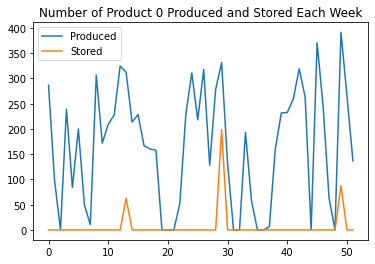

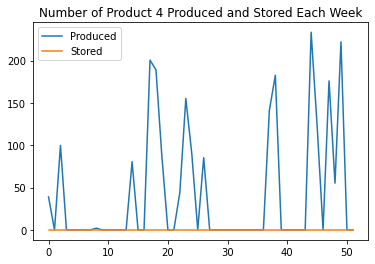

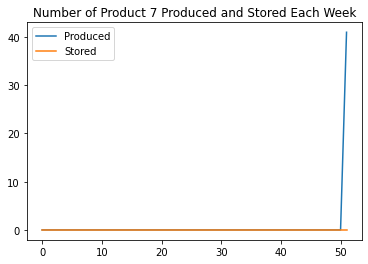

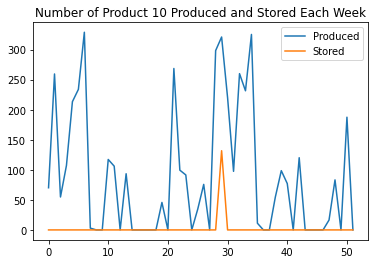

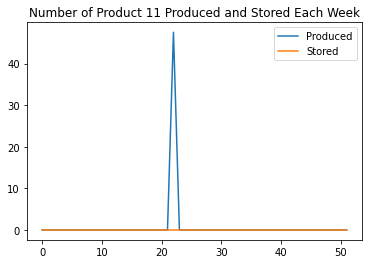

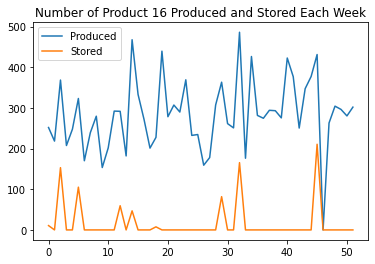

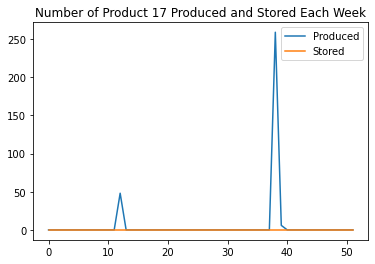

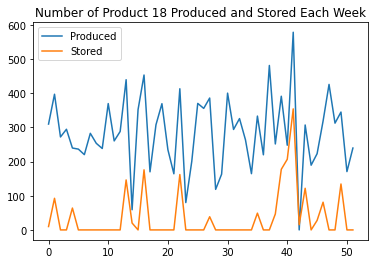

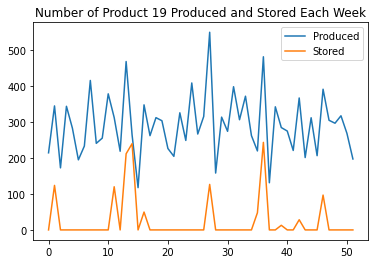

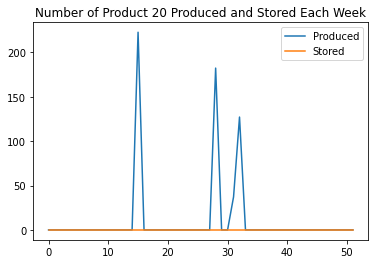

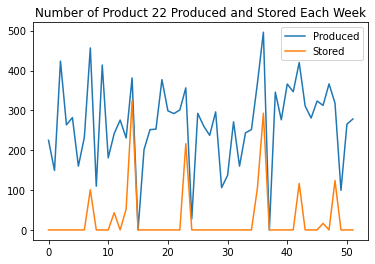

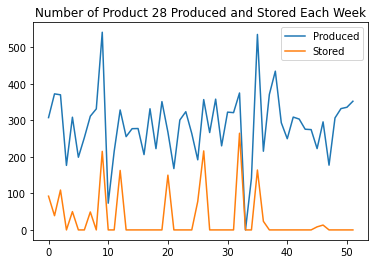

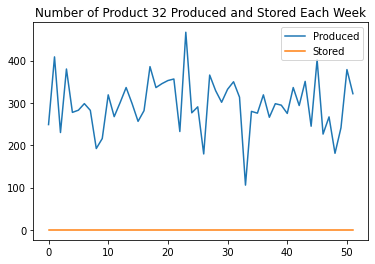

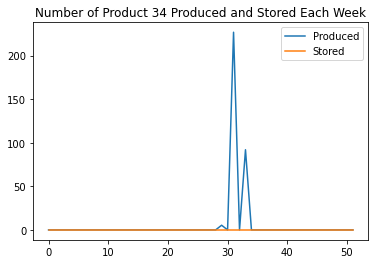

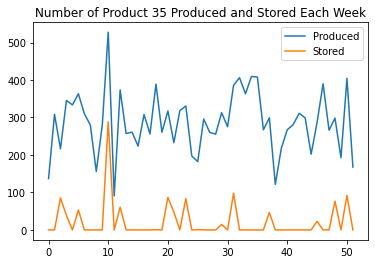

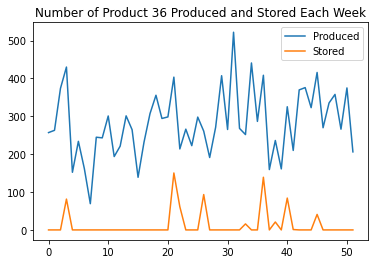

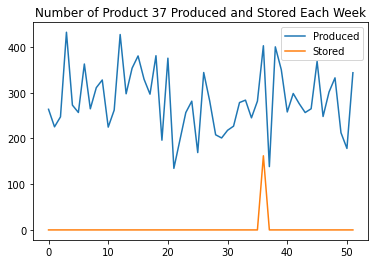

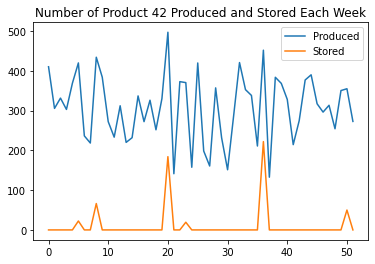

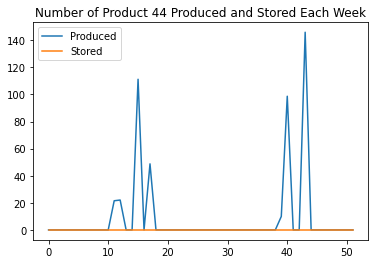

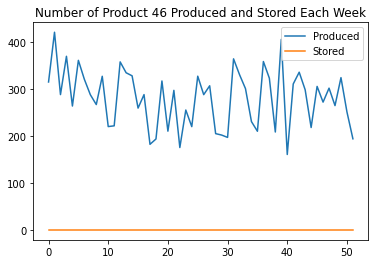

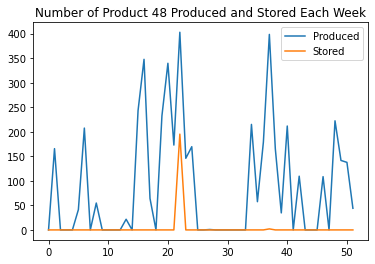

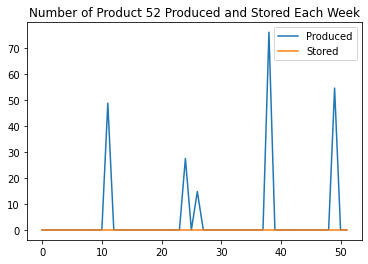

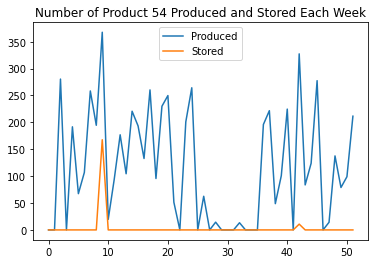

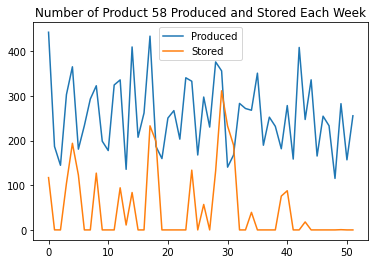

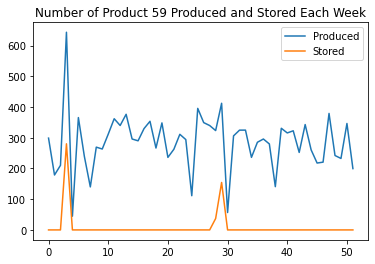

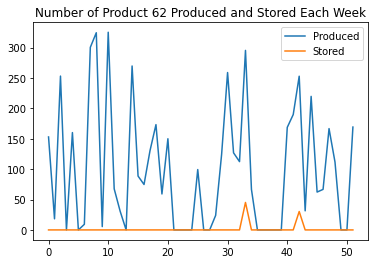

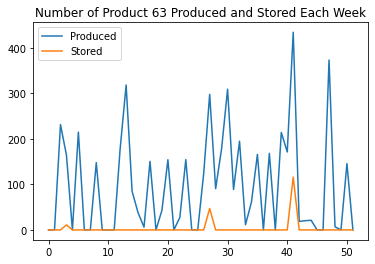

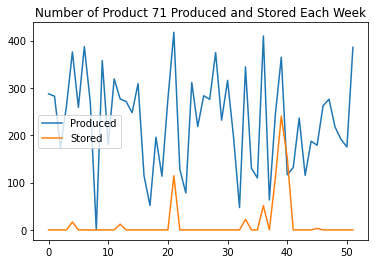

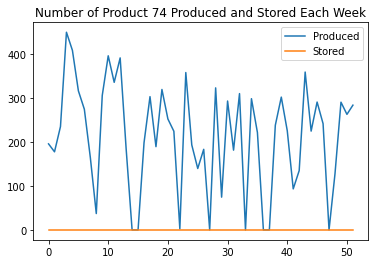

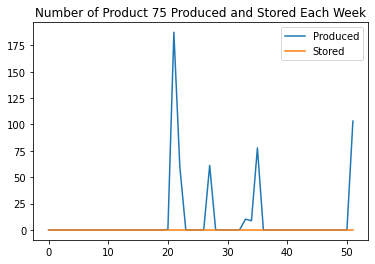

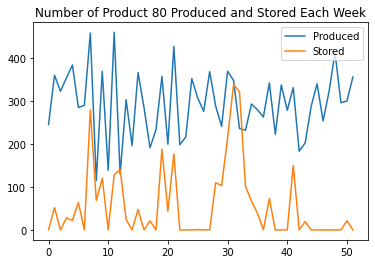

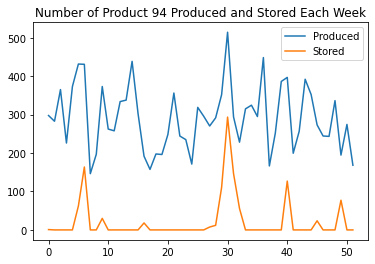

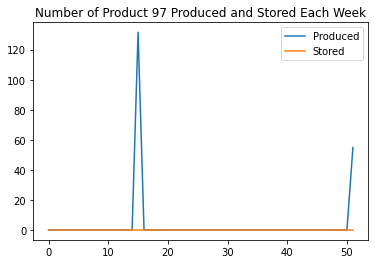

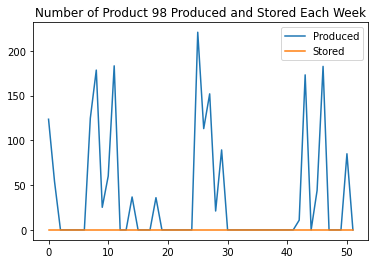

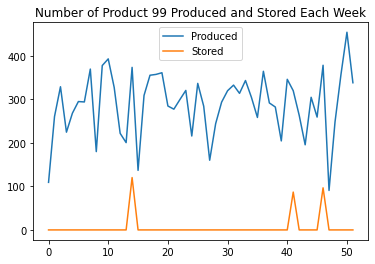

In [18]:
all_product_count = []
all_stored_count = []
for i in products:
    product_count = []
    stored_count = []
    for t in weeks:
        product_count.append(x[i, t].x)
        stored_count.append(e[i, t].x)
    all_product_count.append(product_count)
    all_stored_count.append(stored_count)
    if sum(product_count)>0:
        plt.plot(weeks, product_count, label='Produced')
        plt.plot(weeks, stored_count, label='Stored')
        plt.title('Number of Product ' + str(i) + ' Produced and Stored Each Week')
        plt.legend()
        plt.show()

How many materials were fully utilized in week 30?

In [19]:
total_materials_used_30 = []
for j in materials:
    j_used = 0
    for i in products:
        j_used += reqs[i, j] * x[i, 29].x
    total_materials_used_30.append(j_used)

materials_available_30 = [avail[j, 29] for j in materials]
sum([materials_available_30[j] - round(total_materials_used_30[j]) == 0 for j in materials])

9

For how many of the 100 product types was demand fully met?

In [20]:
products_sold_30 = []
for i in products:
    products_sold_30.append(s[i, 29].x)

demand_30 = [demand[i, 29] for i in products]
sum([demand_30[i] - products_sold_30[i] == 0 for i in products])

19